In [1]:
# solve Don't Overfit II with Decision Tree and Random Forest

In [20]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import LeaveOneOut

In [24]:
train = pd.read_csv("../data/train.csv").sample(frac=1.0)
test = pd.read_csv("../data/test.csv")
submission = pd.read_csv("../data/sample_submission.csv")

In [86]:
X = train.drop(['id', 'target'], axis=1)
y = train['target']
X_test = test.drop(['id'], axis=1)

In [87]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True)
#repeated_folds = RepeatedStratifiedKFold(n_splits=20, n_repeats=20, random_state=42)

#scaler = StandardScaler()
#X = scaler.fit_transform(X)
#X_test = scaler.transform(X_test)

In [27]:
from sklearn.model_selection import GridSearchCV

In [30]:
def get_predictions(x):
    return [1 if xi >= 0.5 else 0 for xi in x]

In [ ]:
# we don't know the targets for the test data so we can only use the train data

In [83]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

acc = []
for depth in range(1,30):
    rfc = RandomForestClassifier(max_depth=depth).fit(X,y)
    print(rfc.predict_proba(X_test)[:,1])
    acc.append(roc_auc_score(, rfc.predict_proba(X_test)[:,1]))
    break
    
#plt.plot([x for x in range(1,30)], acc)

[0.63368903 0.64277423 0.635861   ... 0.62605824 0.65116898 0.66309254]


ValueError: Found input variables with inconsistent numbers of samples: [250, 19750]

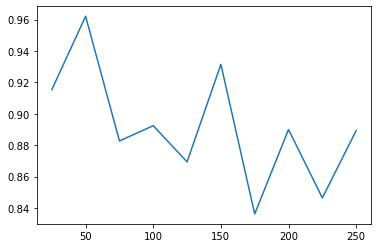

In [48]:
# Random Forest
n_estimators = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250]
max_estimators = []
for x in range(0,25):
    acc = []
    
    for n in n_estimators:
        rfc = RandomForestClassifier(max_depth=9, n_estimators=n).fit(X,y)
        acc.append(rfc.predict_proba(X_test)[:,1])
        
    max_estimators.append(acc.index(max(acc)))
    
plt.plot(n_estimators, acc)

(array([7., 4., 3., 4., 0., 1., 1., 1., 1., 3.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

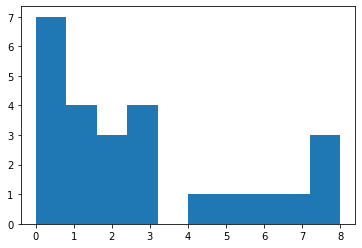

In [49]:
plt.hist(max_estimators)

In [50]:
# leave one out training method - cross valiation
loo = LeaveOneOut()
preds = np.zeros(len(y))
for i, (train_index, test_index) in enumerate(loo.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train = y[train_index]
    rfc = RandomForestClassifier(max_depth=9, n_estimators=50).fit(X_train, y_train)
    preds[test_index] = rfc.predict_proba(X_test)[:,1]

print(f"Random Forest: {roc_auc_score(y, preds)}")
print(classification_report(y, get_predictions(preds)))

Models AUC score: 0.5148611111111111
              precision    recall  f1-score   support

         0.0       0.29      0.04      0.08        90
         1.0       0.64      0.94      0.76       160

    accuracy                           0.62       250
   macro avg       0.46      0.49      0.42       250
weighted avg       0.51      0.62      0.51       250



In [28]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

In [60]:
dtc = DecisionTreeClassifier()

parameter_grid = {'max_features': [25, 50, 75, 100, 150, 200],
                  'max_depth': [3, 5, 10, 15]
                 }

grid_search = GridSearchCV(rfc, param_grid=parameter_grid, cv=folds, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=20, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(max_depth=3, n_estimators=1000),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10, 15],
                         'max_features': [25, 50, 75, 100, 150, 200]},
             scoring='roc_auc')

In [61]:
grid_search.best_params_

{'max_depth': 5, 'max_features': 75}

In [64]:
# leave one out training method - cross valiation
loo = LeaveOneOut()
preds = np.zeros(len(y))
for i, (train_index, test_index) in enumerate(loo.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train = y[train_index]
    dtc = DecisionTreeClassifier(**grid_search.best_params_).fit(X_train, y_train)
    preds[test_index] = dtc.predict_proba(X_test)[:,1]

print(f"Decision Tree AUC score: {roc_auc_score(y, preds)}")
print(classification_report(y, get_predictions(preds)))

Decision Tree AUC score: 0.45145833333333335
              precision    recall  f1-score   support

         0.0       0.35      0.28      0.31        90
         1.0       0.64      0.71      0.67       160

    accuracy                           0.56       250
   macro avg       0.49      0.50      0.49       250
weighted avg       0.53      0.56      0.54       250



In [79]:
preds

array([0.44444444, 1.        , 0.92857143, 0.77419355, 0.97619048,
       1.        , 0.77777778, 0.90384615, 1.        , 0.90804598,
       0.82352941, 0.33333333, 0.03846154, 0.6       , 0.94642857,
       0.87155963, 0.80232558, 0.65517241, 0.91176471, 1.        ,
       1.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.81560284, 1.        , 1.        , 0.39130435,
       0.        , 0.66666667, 1.        , 0.        , 0.87179487,
       1.        , 0.67532468, 0.88      , 1.        , 0.8       ,
       0.86956522, 0.80487805, 0.14285714, 0.85074627, 1.        ,
       0.97222222, 0.7       , 0.88235294, 1.        , 0.93023256,
       0.9375    , 0.10526316, 0.72807018, 1.        , 0.        ,
       0.9       , 0.        , 0.        , 0.73913043, 0.90909091,
       0.92405063, 0.91358025, 0.21052632, 1.        , 0.859375  ,
       0.83846154, 0.22222222, 0.91666667, 0.91111111, 0.92941176,
       0.        , 1.        , 0.76923077, 0.86324786, 0.83088